<font size = +3><center><u> Predicting Seasonal Flu Vaccine Demand for AmerisourceBergen </u></center></font>

Roshni Janakiraman

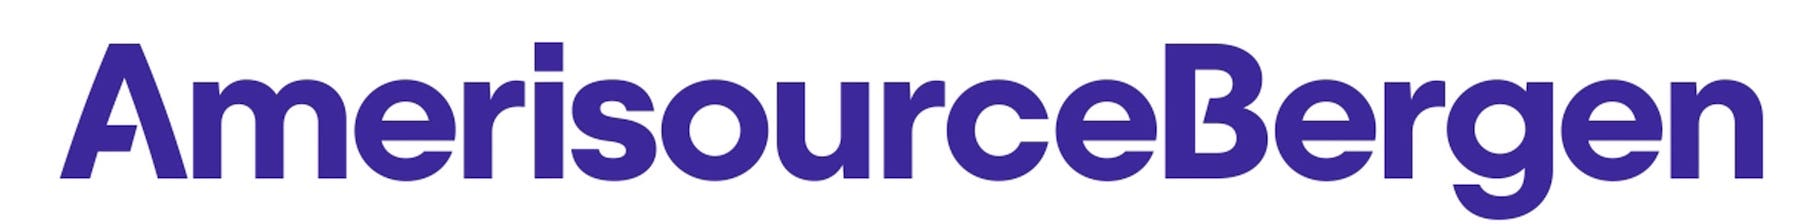

# Introduction

## Business Overview and Objectives

2022 marked one of the [worst flu seasons](https://www.vox.com/2022/12/6/23494948/flu-influenza-rsv-covid-vaccine-chart-tripledemic-tridemic) in the past 5 years. Broadly available vaccines are crucial to addressing this issue.

As one of the largest medical distributors in America, [AmerisourceBergen](https://www.amerisourcebergen.com/insights/physician-practices/supporting-flu-vaccine-access) is committed to making sure that there is an ample supply of seasonal flu vaccines, available to patients whenever and wherever they may need them. AmerisourceBergen prioritizes **empowering customers with increased access to seasonal flu vaccines** through their innovative distribution model, which involves:

    1. Ensuring reliable and timely vaccine deliveries to their customers (retail pharmacies, healthcare providers)
    2. Forming relationships with multiple vaccine manufacturers & providing insight on market trends
    3. Innovating supply chain & logistic management to have the right supply in the right place, at the right time

Each of these objectives is reliant upon **early planning**: accurate prediction of supply & demand is necessary to ensure patients can get vaccinated as early in the flu season, as possible.

Therefore, the current project seeks to identify the **best predictive model** for AmeriSourceBergen to use to accurately predict future flu vaccine recipients. Being able to identify which individuals are the most likely to get the flu vaccine can help AmerisourceBergen:

    1. Coordinate supply needs with vaccine manufacturers early, ensuring reliable supply
    2. Optimize nationwide supply chain and logistic planning: planning the best ordering & shipping practices to ensure vaccine demand is met across the nation.
    3. Expedite vaccine providers receiving flu shot orders and maintaining AmerisourceBergen's reputation as a reliable healthcare product distributor.
    
    

## Project Objectives

The current project seeks to use predictive modeling to accurately identify people who are likely to receive the seasonal flu vaccine in the future, therefore allowing AmerisourceBergen to predict vaccine demand. The following business questions guide our exploration:

1. Based on previous data, can a machine learning model be trained to accurately identify seasonal flu vaccine recipients? 


2. What *types* of seasonal flu vaccines should AmerisourceBergen offer customers? Using the machine learning model, can we predict how much of each vaccine AmerisourceBergen should invest in and plan to distribute nationwide?


3. What role can AmerisourceBergen have in increasing vaccination rates nationwide? Can AmerisourceBergen play an active role in influencing vendor or client behavior to support vaccination efforts?

# Data Understanding

## Setting Up Notebook & Dataset

In [106]:
# Importing Packages Used

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score,\
    accuracy_score, precision_score, f1_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [107]:
# Notebook Set-Up for Graphs

sns.set_theme(context='notebook', palette="Set2", 
              style='white', font='sans-serif', font_scale = 1.2, 
              color_codes=True, rc={'figure.figsize':(16,10)})

%matplotlib inline

In [108]:
# Create Training Dataset: Import & Merge Training Set Features & Labels

training_set_features = pd.read_csv('data/training_set_features.csv')
training_set_labels = pd.read_csv('data/training_set_labels.csv')

df = pd.merge(training_set_features, training_set_labels,  how='inner', on='respondent_id')

FileNotFoundError: [Errno 2] No such file or directory: 'data/training_set_features.csv'

In [ ]:
## First Examination of the data

df.info()

In [ ]:
df.describe()

In [ ]:
df.describe(include=object)

## Data Exploration

### Feature Selection

The following exclusion criteria was used to retain the most relevant features for analyses:

1. Features irrelevant to current question
   * Respondent ID (no real life meaning)
   * H1N1-centric variables (since the current project only focuses on the seasonal flu vaccine)
   
   
2. Features with excessive missing data ( >20% missing)

In [ ]:
df.columns

#### Features Irrelevant to Current Question

In [ ]:
# Remove irrelevant variables from dataset

df.drop(['respondent_id', 'h1n1_vaccine', 'h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1',
         'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc'], 
        axis=1, inplace=True)

#### Features with Excessive Missing Data

I identified and individually examined all variables with greater than 10% of their data missing

In [ ]:
gap_cols = []

for col in df.columns:
    if df[col].isna().sum() > 0.1* len(df.index):
        gap_cols.append(col)

print("Columns with >10% missing data:")
gap_cols

##### Actually Missing Data: Examining Health_Insurance and Income_Poverty

In [ ]:
print("\t Income Poverty:")
print(df['income_poverty'].value_counts(normalize=True, dropna=False))

print("\n \t Health Insurance:")
print(df['health_insurance'].value_counts(normalize=True, dropna=False))

##### Not Actually Missing Data: Employment_Industry and Employment Occupation

* Data dictionary indicates employment_industry and employment_occupation are not actually missing. The missing data is because the question was only asked if employment status = "Employed"
  * I will impute "Not Employed" in place for anyone who reported Not Employed below:
  
* However, given large amount of categories (44 columns to be created), inability to bin categories as data has been anonymized, and inability to interpret categories- worth dropping.

* *Income Poverty:* **Retain**
    * only 16% of the data is missing & processing pipeline includes imputation.
    
* *Health Insurance:* **Drop**
    * 45% missing, no indication as to why. 
    * Futher, Classes are incredibly imbalanced. 
    * Therefore, might be best to drop instead of impute

In [ ]:
df.drop(['health_insurance', 'employment_industry', 'employment_occupation'], axis=1, inplace=True)

### Describing Variable Types

* Outcome Variable - Seasonal Vaccine - Binary (0/1: have/not)

* *No continuous variables* in this dataset. All variables are either binary, categorical or ordinal.

* Identifying binary, ordinal, and categorical columns:
    1. Using Python and rules of thumb to do a first sort
    2. Adjusting first sort based on knowledge & category examination

In [ ]:
binary_col = []
ordinal_col = []
categor_col = []

for col in df.columns:
    if len(df[col].value_counts().index) == 2:
        binary_col.append(col)
    elif col in df.select_dtypes(np.number).columns:
        ordinal_col.append(col)
    else:
        categor_col.append(col)

Rule of thumb divide needed some editing:
* Age_group, education, and income_poverty are **ordinal** (there is a clear order to them), even though they are coded as objects

In [ ]:
# Moving age_group, education, income_poverty to ordinal list:

for col in ['age_group', 'education', 'income_poverty']:
    categor_col.remove(col)
    ordinal_col.append(col)

**Variable Descriptions** 

In [ ]:
print("Binary Columns:")
print(df[binary_col].dtypes)
print("\nOrdinal Columns:")
print(df[ordinal_col].dtypes)
print("\nCategorical Columns:")
print(df[categor_col].dtypes)

### Exploring the Outcome Variable: Seasonal Vaccine

The **outcome variable** of interest is Seasonal_Vaccine, a binary variable.

* 0: Participant Received the Seasonal Flu Vaccine
* 1: Participant Did Not Receive the Seasonal Flu vaccine

In [ ]:
# Breakdown by count and ratio:

print(pd.DataFrame(df['seasonal_vaccine'].value_counts().values, index=['No', 'Yes'], columns = ['Count']))

print(pd.DataFrame(df['seasonal_vaccine'].value_counts(normalize=True).values, index=['No', 'Yes'], columns = ['Ratio']))

In [ ]:
# Graph of Flu Vaccine Recipients (Yes/No) by Percentage (%)

percent = list((df['seasonal_vaccine'].value_counts(normalize=True).values*100).astype(int))

vax = sns.barplot(x = ['No', 'Yes'], y = percent)
vax.set_ylabel("Percent of Total Sample (%)")
vax.set_ylim(0, 80)
vax.set_title('Received Seasonal Flu Vaccine', fontsize=20);

for loc, label in enumerate(percent):
    vax.text(loc, label+2, (str(int(round(label, ndigits=0))) + '%'), ha='center', fontsize=14);

**Takeaways about Seasonal Flu Vaccine Distribution:**

* Similar breakdown of Yes/No Responses: close to 50-50
* Fairly Balanced Classes
    * Beneficial for many machine learning algorithms

### Exploring Predictor Variables: Distributions

Using Bar Plots to examine predictor variable distributions:

In [ ]:
# Taking only predictor variables & making categorical variables to numeric, to avoid x label overlap
graph_df = df.copy()
graph_df.drop('seasonal_vaccine', axis=1, inplace=True)

for col in list(graph_df.select_dtypes(object).columns):
    k = (list(df[col].value_counts().index))
    v = range(0, len(df[col].value_counts().index))
    data_dict = dict(zip(k,v))
    graph_df = graph_df.replace({col:data_dict})

In [ ]:
# Temporarily converting Age_Group, Education, Income_Poverty to Numeric to make ordinal for data exploration:

age_group_key = dict(zip(list(graph_df['age_group'].value_counts().index), [5, 4, 3, 1, 2]))
education_key = dict(zip(list(graph_df['education'].value_counts().index), [4, 3, 2, 1]))
income_poverty_key = dict(zip(list(graph_df['income_poverty'].value_counts().index), [2, 3, 1]))

In [ ]:
graph_df = graph_df.replace({'age_group': age_group_key, 'education': education_key, 'income_poverty': income_poverty_key })

In [ ]:
fig, ax = plt.subplots(4,4, figsize=(16,16))

for i, col in enumerate(graph_df.columns[0:16]):
    ax1 = i//4
    ax2 = i%4
    x = list(graph_df[col].value_counts().index)
    y = list((graph_df[col].value_counts(normalize=True).values)*100)
    sns.barplot(data=graph_df, x=x, y=y, ax=ax[ax1][ax2]).set(xlabel=col, ylabel='Dist Percentage (%)', ylim = (0, 100))
    
plt.tight_layout();

In [ ]:
fig, ax = plt.subplots(2,5, figsize=(20,12))

for i, col in enumerate(graph_df.columns[16:]):
    ax1 = i//5
    ax2 = i%5
    x = list(graph_df[col].value_counts().index)
    y = list((graph_df[col].value_counts(normalize=True).values)*100)
    sns.barplot(data=graph_df, x=x, y=y, ax=ax[ax1][ax2]).set(xlabel=col, ylabel='Dist Percentage (%)', ylim = (0, 100))
    
plt.tight_layout();

### Overall Relationships Between Variables

#### Graphing Seasonal Vaccine breakdown by Category for each Predictor

In [ ]:
fig, ax = plt.subplots(4,4, figsize=(16,16))

for i, col in enumerate(graph_df.columns[0:16]):
    x = i//4
    y = i%4
    pd.crosstab(graph_df[col], df['seasonal_vaccine'], normalize='index').plot(kind='bar', ax=ax[x][y], legend=False)

plt.tight_layout()
plt.legend(
    loc='center', 
    bbox_to_anchor=(1.2, 4.5), 
    title='flu_vaccine'
);

<b><u> Observations Part 1: </u></b>

* Behavioral Variables:
   * All show probable relationship to seasonal vaccine status except for *antiviral-meds*
       * Anti-Viral meds: similar distribution regardless of vaccination status.
       

* Opinion Variables:
    * Clear relationships for effectiveness & risk
    * Murky relationship for sick_from_vaccine
        * Possible that some people who fear getting sick from the vaccine would be more afraid of getting the flu
        
     
* Misc variables: 
    * *Strong relationships:* Doctor Recommendation, Chronic Med Condition, Health Worker, Age Group, Education
    * *Weak/Murky Relationships*: Child Under 6 months
 

In [ ]:
fig, ax = plt.subplots(2,5, figsize=(20,12))

for i, col in enumerate(graph_df.columns[16:]):
    x = i//5
    y = i%5
    pd.crosstab(graph_df[col], df['seasonal_vaccine'], normalize='index').plot(kind='bar', ax=ax[x][y], legend=False)

plt.tight_layout()
plt.legend(
    loc='center', 
    bbox_to_anchor=(1.2, 1.5), 
    title='flu_vaccine'
);

<b><u> Observations Part 2: </u></b>

**Notable Relationships:** Race, Sex, Income_Poverty, Rent or Own, Employment Status, Household Children

**Probable Relationships:** Marital Status, Household_Adults

**Murky Relationships:** HHS_Geo_Region, MSA

## Data Quality

### Data Reliability: Faulty Data?

* Most of the data seems reliable: does not raise concerns about notability.


* However, possible Faulty Data in one column:

    1. Household_adults
        * How can there be 0 adults in a household? 
        * Need to examine data dictionary

* Based on [CDC data dictionary](https://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/NIS/nhfs/nhfspuf_CODEBOOK.PDF), Number of Adults should range from 1 - 4, not 0 - 3

* Will reformat household_adults in Data Preparation section for clarity.

### Missing Data

* Already dealt with columns with significant missing data in Feature Selection section (2.1)

* Columns with some/any amount of missing data: all but 6
    * Imputation will be needed

**Imputation Strategy:**

Imputation will be handled in the Processing Pipeline
 * Binary, Categorical, and Ordinal Objects - impute with "Most Frequent"
 * Numeric Ordinal - impute with Median

### Variable Types

* As noted in Variable Description, there are 3 Ordinal Variables that are currently only being treated as Categorical, will be changed in data prep:
    1. Age Group
    2. Education
    3. Income
    
    
* Otherwise, data types match variables

# Business Insights from Data Exploration

## Encouraging Doctor Recommendations

* Many of AmerisourceBergen's clients are healthcare providers, and both parties would benefit from increasing the nationwide vaccination rate.

* How can AmerisourceBergen support efforts to encourage people to get vaccinated?

In [ ]:
plot1 = (pd.crosstab(df['doctor_recc_seasonal'], df['seasonal_vaccine'], normalize='index')).plot(kind='bar', figsize = (10, 6), rot=0, legend=False)
plot1.set_title('Flu Vaccine Recipients based on Doctor Recommendation')
plot1.set_xlabel('Doctor Recommendation')
plot1.set_xticklabels(['No', 'Yes'])
plot1.set_ylabel("Percent Distribution")
plot1.yaxis.set_major_formatter("{:.0%}".format)
plot1.legend(
    loc='center', 
    bbox_to_anchor=(1.3, 0.5), 
    title='Received Flu Vaccine',
    labels=['No','Yes']);

plt.savefig('docrec.png', facecolor='white', transparent=False)

* People who receive a doctor's recommendation are more likely to get the flu vaccine, whereas those who don't are more likely not to get the flu vaccine

* In total, only 33% of people are recommended to get the vaccine by their doctor

* AmerisourceBergen should continue to advocate for doctors to talk about seasonal flu vaccines during appointments, even when its not flu season

* In addition, AmerisourceBergen can provide marketing information and tools (e.g. promotional brochures, pamphlets, goodies) to doctors to facilitate the recommendation process and build customer goodwill.

## Vaccine Inventory Planning: Types of Seasonal Flu Vaccines & Demographics

Each flu season, the [CDC approves](https://www.cdc.gov/flu/prevent/flushot.htm#:~:text=Several%20different%20brands%20of%20standard,(muscle)%20with%20a%20needle) multiple types of flu vaccines, each with specific functions based on the needs of different subpopulations.

The current analyses focuses on the needs of two sub-populations that get the vaccine at higher rates: 
    * Elderly people (above the age of 65)
    * People with Chronic Illness

### Seasonal Flu Vaccines for the Elderly

* The CDC does not approve the standard seasonal flu vaccine for elderly patients

* Patients over 65 must get one of the following flu vaccines instead:
    1. High Dose Flu Shot (Fluzone High-Dose Quadrivalent)
    2. Adjuvated Flu Shot (Fluad Quadrivalent)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,5))

age_plot = pd.crosstab(df['age_group'], df['seasonal_vaccine']).plot(kind='bar', ax=ax[0], rot=0, \
        title = 'Vaccine Status Count by Age', xlabel=('Age Group'), ylabel=('Number of People'))
age_plot.legend(labels=['No','Yes'])


vaccinated = df[df['seasonal_vaccine'] == 1]
vaxd_age_plot_x = (df['age_group'].value_counts(normalize=True)).sort_index().index
vaxd_age_plot_y = (df['age_group'].value_counts(normalize=True)).sort_index().values*100

vaxd_age_plot = sns.barplot(x = vaxd_age_plot_x, y = vaxd_age_plot_y)
vaxd_age_plot.set_title('Received Vaccine - Percent by Age')
vaxd_age_plot.set_ylabel("Percent (%)")
vaxd_age_plot.set_ylim(0, 40)
vaxd_age_plot.set_xlabel('Age Group');

plt.savefig('age.png', facecolor='white', transparent=False)

* The elderly make up the largest group of vaccine recipients: a much larger number of elderly people received the flu vaccine than any other age group.

* The elderly make up 25% of all vaccinated people - a higher percentage than any other age group.

* AmerisourceBergen should prioritize stocking and offering a reasonable amount of Fluzone High-Dose Quadrivalent and Fluad Quadrivalent vaccines.

### Seasonal Flu Vaccine in People with Chronic Illness

* The CDC recommends that people with weakened immune systems get the [Recombitant Flu Shot](https://www.cdc.gov/flu/prevent/flushot.htm#:~:text=Several%20different%20brands%20of%20standard,(muscle)%20with%20a%20needle.), which creates a stronger immune response

* Therefore, it is important to consider the distribution of people with chronic illness who receive the flu vaccine:

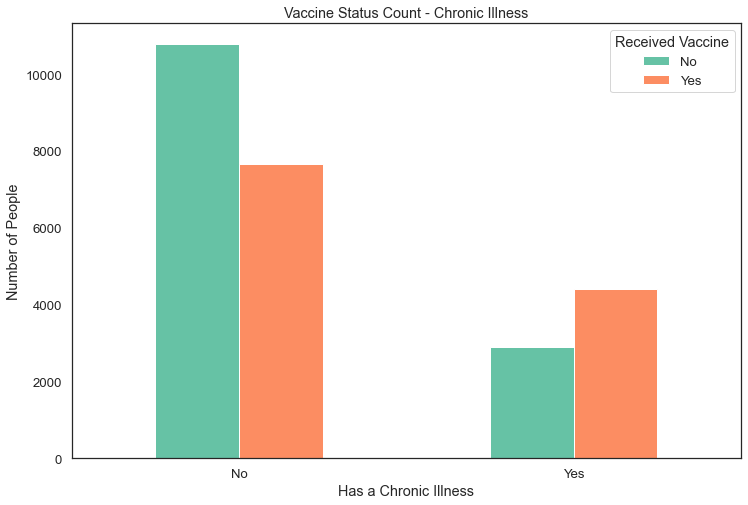

In [109]:
crosstabs = pd.crosstab(df['chronic_med_condition'], df['seasonal_vaccine'])
crosstabs = crosstabs.rename(columns={0:'No', 1:'Yes'}, index={0:'No',1:'Yes'})
crosstabs = crosstabs.rename_axis("Has a Chronic Illness")
crosstabs = crosstabs.rename_axis("Received Vaccine", axis=1)

crosstabs.plot(kind='bar', rot=0, ylabel = 'Number of People', title='Vaccine Status Count - Chronic Illness', figsize=(12, 8));

plt.savefig('exp_chronill.png', facecolor='white', transparent=False)

* Although the number of vaccine recipients with Chronic Illness is lower than the number of vaccine recipients without a chronic illness, a significant portion of the chronically ill population get the vaccine

* A greater ratio of people with chronic illness are vaccinated compared to people without chronic illness.
    * Perhaps people with chronic illness place greater priority on getting the flu vaccine

* AmerisourceBergen should consider offering and marketing a proportional supply of Recombitant Vaccines

**Overall:**
* A higher proportion of these subpopulations get the flu vaccine; therefore, AmerisourceBergen should consider its inventory planning with that in consideration

* Further, since the predictive model will predict future vaccine recipients based on demographic data, it can also be used to estimate how many of the special types of vaccines to order.

* These data exploration insight provides further use for the predictive model to be built in the following steps.

# Data Preparation

## Reformatting Variables

In [110]:
### RECODING HOUSEHOLD_ADULTS

# Changing range of household_adults from 0-3 to 1-4

df['household_adults'] = df['household_adults'].map(lambda x: x+1)
df['household_adults'].value_counts().sort_index()

2.0     8056
3.0    14474
4.0     2803
5.0     1125
Name: household_adults, dtype: int64

In [111]:
### REFORMATTING VARIABLE NAMES

# Census_MSA:
new_msa = dict(zip(list(df['census_msa'].value_counts().index), ['MSA-NPC', 'MSA-PC', 'Non-MSA']))
df['census_msa'].replace(new_msa, inplace=True)
df['census_msa'].value_counts()

MSA-NPC    11645
MSA-PC      7864
Non-MSA     7198
Name: census_msa, dtype: int64

In [112]:
df['education'].value_counts().index

Float64Index([4.0, 3.0, 2.0, 1.0], dtype='float64')

In [113]:
### MAKING SURE ORDINAL VARIABLES ARE ORDERED

# For ease of processing, I am going to recode to numeric variables, 
# since OrdinalEncoder would do that anyways & I would need to reformat anyways.

age_group_key = dict(zip(list(df['age_group'].value_counts().sort_index().index), [1, 2, 3, 4, 5]))
df['age_group'].replace(age_group_key, inplace=True)

income_poverty_key = dict(zip(list(df['income_poverty'].value_counts().index), [2, 3, 1]))
df['income_poverty'].replace(income_poverty_key, inplace=True)

education_key = dict(zip(list(df['education'].value_counts().index), [4, 3, 2, 1]))
df['education'].replace(education_key, inplace=True)

## Data Construction

### Composite Behavioral & Opinion Variables

1. Behavioral Composite
    * Combine all 7 behavioral variables into a variable representing "Flu Behavioral Conscientiousness"
2. Opinion Composite
    * Combine all 3 opinion variables into a variable representing "Pro-Vaccine Attitude"

In [114]:
df['behav_comp'] = df[list(df.columns)[:7]].sum(axis=1)

df['opinion_comp'] = df['opinion_seas_vacc_effective'] + df['opinion_seas_risk'] + \
(6 - df['opinion_seas_sick_from_vacc'])

drop_col = list(df.columns)[:7] + list(df.columns)[11:14]
df.drop(drop_col, axis=1, inplace=True)

KeyError: 'opinion_seas_vacc_effective'

In [ ]:
df.columns

In [ ]:
# Exploring Distribution of Behavioral Composite

sns.barplot(data=df, x=df['behav_comp'].value_counts().index, y=df['behav_comp'].value_counts(normalize=True).values);

In [ ]:
sns.barplot(data=df, x=df['opinion_comp'].value_counts().index, y=df['opinion_comp'].value_counts(normalize=True).values);

## Updating Variable Type Descriptions Post- Data Cleaning

In [ ]:
binary_col = []
ordinal_col = []
categor_col = []

for col in df.columns:
    if len(df[col].value_counts().index) == 2:
        binary_col.append(col)
    elif col in df.select_dtypes(object).columns:
        categor_col.append(col)
    else:
        ordinal_col.append(col)

In [ ]:
print(df[binary_col].dtypes)

In [ ]:
# Make all binary variables numeric to create a singular "Binary" pipeline:

df['male_or_female'] = df['sex'].replace({'Male':0, 'Female':1})
df.drop('sex', axis=1, inplace=True)
binary_col.remove('sex')
binary_col.append('male_or_female')

df['marital_status'] = df['marital_status'].replace({'Not Married':0, 'Married':1})

df['rent_or_own'] = df['rent_or_own'].replace({'Rent':0, 'Own':1})


In [ ]:
print(df[ordinal_col].dtypes)

* Now, all ordinal cols are numeric

* Numeric columns = all binary and ordinal columns in this dataset

In [ ]:
print(df[categor_col].dtypes)

In [ ]:
# Sum of categories: how many new variables will we create through OneHotEncoding?

num_ohe_cols = 0

for col in categor_col:
    num_ohe_cols += len(df[col].value_counts().index)

num_ohe_cols

## Splitting Data

In [ ]:
# Separate X, y

X = df.drop('seasonal_vaccine', axis=1)
y = df['seasonal_vaccine']

In [ ]:
# Train-test split before pipelines

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Pre-Processing Pipelines

General Strategy Overview:

1. Imputation: numeric = mean, categorical = most frequent
2. Encoding: One Hot Encoder for categorical columns
3. Scaling: StandardScaler()

In [ ]:
# 2. Numeric Columns:

num_pipe = Pipeline([
    ('num_impute', SimpleImputer(strategy='mean')),
    ('ss', StandardScaler())
])

In [ ]:
# 3. Categorical Columns:

cat_pipe = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder())
])

In [ ]:
# Column Transformer

CT = ColumnTransformer(transformers=[
    ('num_tr', num_pipe, selector(dtype_include=np.number)),
    ('cat_tr', cat_pipe, selector(dtype_include=object)),
], remainder='passthrough')

In [ ]:
# X_train_scaled

prep_pipe = Pipeline([('prep', CT),])
X_train_sc = prep_pipe.fit_transform(X_train)

# Data Modeling

## Modeling Strategy

<b><u>Modeling Techniques:</u></b>
* I chose to use Tree-Based Machine Learning Algorithms because:
    1. The current dataset is primarily categorical, which tree models are more [capable of handling](https://www.jmlr.org/papers/volume19/16-474/16-474.pdf).
    2. The proposed model works with a large amount of data (n = 26707) and a large amount of potential predictive variables, which tree-based models are capable of handling.

<b><u>Modeling Plan </u></b>
1. Dummy Model (Baseline)
2. Decision Tree (First Simple Model)
3. Random Forest Model
4. Tuned Random Forest (Final Model)

<b><u> Metrics of Interest </u></b>
1. Cross-Validation Score
    * AmerisourceBergen also needs a generalizable model: since population characteristics are constantly changing, the model needs to be able to perform accurately with new data.
    * Cross-Validation Score allows us to estimate test accuracy with our training models, and indicates how well the model will perform with new data in the future.
    
    
2. Training Score Accuracy (gauge overfitting by comparing with Cross-Validation score)
    * Tree-based models tend to suffer from overfitting
    * To reduce overfitting in our model, we will compare the difference between training score accuracy and cross-validation score. This will also give us insight into generalizability.
    
    
3. ***Top Priority***: Final Model - Test Accuracy Score
    * For supply and logistics planning, AmerisourceBergen needs to predict those who will actually get the vaccine: therefore, **test score accuracy** is the most important metric of model success.
    
4. Final Model - Recall Score
    * Recall score represents the ratio of model-predicted vaccine recipients out of all of the people who actually get the vaccine.
    * Therefore, recall score tells us how accurately the model can predict vaccine demand: out of all of the people who want a vaccine, how many can the model correctly identify?

#### Model with CV Function

This function makes it easier to get the cross-validation score and create a violin plot, making modeling easier.

In [ ]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

## Baseline Model

In [ ]:
dummy_model = Pipeline([
    ('prep', CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

In [ ]:
dummy = dummy_model.fit(X_train, y_train)

In [ ]:
dummy_model_pipe = ModelWithCV(dummy_model, model_name = 'dummy_model', X=X_train, y=y_train)

In [ ]:
dummy_model_pipe.print_cv_summary()

fig, ax = plt.subplots()

dummy_model_pipe.plot_cv(ax=ax);

In [ ]:
dummy.score(X_train, y_train)

The <b><u>baseline accuracy score</u></b> is 0.531. Without any pattern recognition, a model can accurately predict the likelihood a person will get the vaccine 53% of the time. 

This is the benchmark for gauging future model performance

## First Simple Model (#1): Decision Tree

In [ ]:
dt_pipe = Pipeline([
    ('prep', CT),
    ('dt', DecisionTreeClassifier(random_state=42))])

dt_fsm = dt_pipe.fit(X_train, y_train)

dt_fsm_cv = ModelWithCV(dt_fsm, model_name = 'dt', X=X_train, y=y_train)

In [ ]:
names = list(X.select_dtypes(exclude=object).columns)\
+ list(dt_fsm['prep'].transformers_[1][1]\
       ['ohe'].get_feature_names(categor_col))

In [ ]:
dt_fsm_cv.print_cv_summary()

fig, ax = plt.subplots()

dt_fsm_cv.plot_cv(ax=ax);

In [ ]:
# Accuracy on total training data

dt_fsm.score(X_train, y_train)

<b><u>First Simple Model Performance:</u></b>

1. Cross Validation Score: Better than Dummy Model (0.664 vs. 0.531)
    * This model is more accurate at predicting vaccine recipients than the dummy
    
2. However training accuracy (0.998) vs. Cross-Validation (0.664) indicates *significant overfitting*
    * Low generalizability of current model

In [ ]:
fsm_dt = dt_fsm['dt']

## Model #2 : Random Forest Model

Since Random Forest Models are built by aggregating Decision Tree Models, they improve model accuracy and reduce overfitting. For Model 2, I decided to compare the performance of a Random Forest Model to the First Simple Model.

In [ ]:
rfc = RandomForestClassifier(random_state=42)

rfc_model_pipe = Pipeline([('ct', CT), 
                           ('rfc', rfc)])

rfm = rfc_model_pipe.fit(X_train, y_train)

random_forest = ModelWithCV(model=rfc_model_pipe,
                          model_name='rfc_model',
                          X=X_train,
                          y=y_train)

In [ ]:
random_forest.print_cv_summary()

fig, ax = plt.subplots()

random_forest.plot_cv(ax=ax);

In [ ]:
rfm.score(X_train, y_train)

<b><u> Model #2: Evaluation </u></b>

1. Improved Accuracy over Decision Tree, as seen by cross-validation score(RFM: 0.756 vs DT: 0.63)

* However, the Random Forest Model is still significantly overfitting data (Training: 0.998; CV: 0.756)

## Process of Tuning Random Forest Model

* To tune this model, I am going to use GridSearch to identify ideal level of Random Forest parameters

### Hyperparameters for Tuning

In [ ]:
model2_params = {}

for key in rfm.get_params().keys():
    if key.startswith('rfc_'):
        model2_params[key] = rfm.get_params()[key]
model2_params

### Tuning Attempt #1:

In [ ]:
params = {
    'rfc__criterion':['gini','entropy'],
    'rfc__max_depth':[1, 5, 10, 25],
    'rfc__max_features':['sqrt', 'log2'],
}


gs = GridSearchCV(estimator=rfc_model_pipe,param_grid=params,cv=10, verbose=2)

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
print(gs.best_params_)
print(f"Accuracy Score of Best Paramters: {gs.best_score_}")

* Model slightly improved with increased max_depth from default (accuracy = 0.763)

* Default parameters best for criterion ('gini') and max_features ('sqrt')

* Round two of parameter testing strategy: look at other parameters + max_depth > 10

### Tuning Attempt #2:

In [ ]:
params2 = {'rfc__max_depth': [10, 25, 50],
           'rfc__min_samples_leaf': [1, 2, 4],
           'rfc__min_samples_split': [0.5, 1.0, 2],
           'rfc__n_estimators': [50, 100, 200]
         }

In [ ]:
gs2 = GridSearchCV(estimator=rfc_model_pipe,param_grid=params2,cv=10, verbose=2)

In [ ]:
gs2.fit(X_train, y_train)

In [ ]:
print(gs2.best_params_)
print(gs2.best_score_)

* Only a very slight improvement in accuracy

* Sets ideal max_depth at 25
* Since the other parameters are maxed out, need to run another Grid Search to find ideal value:

In [ ]:
# Very slight improvement in accuracy.

# Ideal max_depth = 25

# Round 3, lower cv to run faster:

params3 = {
           'rfc__min_samples_leaf': [4, 8, 16],
           'rfc__min_samples_split': [2, 4, 8],
           'rfc__n_estimators': [200, 500, 1000]
         }

gs3 = GridSearchCV(estimator=rfc_model_pipe,param_grid=params3,cv=5, verbose=2)

In [ ]:
gs3.fit(X_train, y_train)

In [ ]:
print(gs3.best_params_)
print(gs3.best_score_)

* GS3 score not much different than GS2

In [ ]:
final_model_params = {'rfc__criterion':'gini', 'rfc__max_features' : 25, 'rfc__max_features' : 'sqrt',\
                    'rfc__max_depth': 25, 'rfc__min_samples_leaf': 4, 'rfc__min_samples_split' : 2, \
                    'rfc__n_estimators' : 200
}

final_model_params

## Final Model (#3) - Tuned Random Forest Model

In [ ]:
rfc_model_pipe.set_params(**final_model_params)
final_rfm = rfc_model_pipe.fit(X_train, y_train)

**Cross-Validation Score**:

In [ ]:
random_forest_final = ModelWithCV(model=rfc_model_pipe,
                          model_name='rfc_model_final',
                          X=X_train,
                          y=y_train)

In [ ]:
random_forest_final.print_cv_summary()

fig, ax = plt.subplots()

random_forest.plot_cv(ax=ax);

**Training Accuracy Score:**

In [ ]:
final_rfm.score(X_train, y_train)

**Final Model - Training Performance**

* Cross Validation Score of 0.764 : not much improvement over Model #2
    * However, Final Model performs much better than First Model and Dummy Model
    
    
* However, final model better than all models at **reducing overfitting** 
    * Training Accuracy Score: 0.84 vs. Cross-Validation: 0.76

# Model Evaluation & Conclusions

## Final Model: Test Accuracy

In [ ]:
print(f"Final Model : Accuracy Score on Test Data = {final_rfm.score(X_test, y_test):.3f}")

* **Final Model Accuracy: 0.77**


* The model has 77% accuracy in predicting the likelihood that someone will get the flu vaccine.

### Classification Report and Confusion Matrix

In [ ]:
y_pred_rfm = final_rfm.predict(X_test)

print(classification_report(y_test, y_pred_rfm))

* **Recall score:** the model accurately predicted **74%** of people who *actually* received the vaccine

### Determining Most Important Features From Final Model

In [ ]:
rfm_top = pd.DataFrame(zip(X_test.columns, final_rfm['rfc'].feature_importances_))
rfm_top = rfm_top.rename(columns={0:'Feature', 1:'Importance'})

In [ ]:
top5 = rfm_top.sort_values(by='Importance', ascending=False)[:5]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
feat_plot = sns.barplot(
    x = top5['Importance'],
    y = ['Metropolitan Area', 'Doctor Recommendation', 'US Region', 'Age Group', 'Education'], 
    orient='h', ax=ax)

feat_plot.set_title('Top 5 Features in Random Forest Model', fontsize=18);
plt.tight_layout()

for loc, label in enumerate(percent):
    vax.text(loc, label+2, (str(int(round(label, ndigits=0))) + '%'), ha='center', fontsize=14);
    
plt.savefig('features.png', facecolor='white', transparent=False)

## Summary of Final Model Evaluation

<b><u>Evaulation of Final Model Test Performance: Important Metrics</u></b>

1. **Test score accuracy** of **77**%
    * The model could accurately distinguish vaccine recipients from non-recipients 77% of the time
    
2. **Recall score** of **74%** 
    * The model accurately predicted 74% of people who *actually* received the vaccine
    * 74% accuracy in estimating vaccine demand

<b><u>Most Important Features in Model:</u></b>
   * **Doctor Recommendation** and **Age Group** - noted in Business Insights section
   * **Location** seems to be the most important predictor of vaccine recipients (represented by both Metropolitan Area and US Region)
   * **Education** is also an important factor in determining future vaccine recipients

## Recommendations, Limitations, and Future Directions

<b><u> Recommendations for Model Deployment </u></b>
* With a 74% recall score, this model has shown that it is capable of predicting future vaccine demand.

* These numbers can be used to estimate supply orders for the 2023 flu season and beyond

* The estimated numbers from this model (y_pred) can also be used to determine the amount of **Elderly & Chronically Ill population** likely to get the vaccine, which can be used to determine **Recombinant** and **High-Dose** flu vaccine orders and demand.


<b><u> Limitations of Current Model</u></b>
* Model is slightly overfit
    * Model does not perform as well on unseen data as the training data
    * The more that future data deviates from training data, the less accurate the model will be
    * Can be addressed by training model on more (especially recent) data, and reducing features.

<b><u> Future Directions </u></b>
1. Include updated, more recent data in model training
2. Obtaining new location metrics & training model on them
    * Greater exploration of location determinants in predicting flu vaccine recipients
    * Since location was confidential in this dataset, having human interpretable location metrics would allow AmerisourceBergen to derive location-based predictions based on the models' output 
        * (e.g. how many people in the Southern part of the United States are likely to get the vaccine?)
        * This will allow AmerisourceBergen to optimize their distribution & shipping routes

